<a href="https://colab.research.google.com/github/rahulyad011/intrusion-detection/blob/main/NIDS1_UNSW_NB15_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model
import pickle # saving and loading trained model
from os import path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# importing library for support vector machine classifier
from sklearn.svm import SVC

# MLP requirements 
from keras.layers import Dense # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.models import model_from_json # saving and loading trained model

# LSTM requirements 
from keras.layers import LSTM
from keras.layers import Input
from keras.models import Model

# evaluation metrices
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# representation of model layers
from keras.utils.vis_utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
bin_data_total = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/nids_project_data/UNSW_NB15_data/bin_data_processed.csv")
bin_data_total.drop(bin_data_total.columns[0],axis=1,inplace=True)
bin_data_total

,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,0,0,0,1,2,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,2,0,0,0,1,2,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,3,0,0,0,1,3,0,0
3,0,0,0,0,0,0,0,0,0,0,...,2,1,3,0,0,0,2,3,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2,1,3,0,0,0,2,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0,0,0,0,0,0,0,0,0,0,...,24,13,24,0,0,0,24,24,0,1
257669,0,0,0,0,0,0,0,0,0,0,...,1,1,2,0,0,0,1,1,0,1
257670,0,0,0,0,0,0,0,0,0,0,...,3,3,13,0,0,0,3,12,0,1
257671,0,0,0,0,0,0,0,0,0,0,...,30,14,30,0,0,0,30,30,0,1


In [4]:
# distribution of label class before sampling
data_size = bin_data_total.shape[0]
# data_size
bin_data_total.label.value_counts()/data_size

1    0.639077
0    0.360923
Name: label, dtype: float64

In [5]:
# numeric feature normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

numeric_cols = bin_data_total.select_dtypes(['number']).columns
numeric_cols = numeric_cols.drop('label')
flag = 0
scaler = None
if flag:
  # using standard scaler for normalizing
  scaler = StandardScaler()
else:
  # using minmax scaler for normalizing
  # to avoid negative values after scaling
  scaler = MinMaxScaler()

def normalization_train(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = scaler.fit_transform(arr.reshape(len(arr),1))
  return df

def normalization_test(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = scaler.transform(arr.reshape(len(arr),1))
  return df

# numeric_cols

In [6]:
# sampling data taking only 50% of the data
# bin_data = bin_data_total.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.5))
bin_data = bin_data_total
bin_data

,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,0,0,0,1,2,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,2,0,0,0,1,2,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,3,0,0,0,1,3,0,0
3,0,0,0,0,0,0,0,0,0,0,...,2,1,3,0,0,0,2,3,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2,1,3,0,0,0,2,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,0,0,0,0,0,0,0,0,0,0,...,24,13,24,0,0,0,24,24,0,1
257669,0,0,0,0,0,0,0,0,0,0,...,1,1,2,0,0,0,1,1,0,1
257670,0,0,0,0,0,0,0,0,0,0,...,3,3,13,0,0,0,3,12,0,1
257671,0,0,0,0,0,0,0,0,0,0,...,30,14,30,0,0,0,30,30,0,1


In [7]:
number_of_cols = bin_data.shape[1]

In [8]:
# distribution of label class after sampling
data_size = bin_data.shape[0]
bin_data.label.value_counts()/data_size

1    0.639077
0    0.360923
Name: label, dtype: float64

In [9]:
model_selection = {
    0 : "ALL",
    2 : "MLP",
    3 : "LSTM",
    4 : "AE"
}
model_flag = 0
svm_enable = 1

In [10]:
X = bin_data.iloc[:,0:number_of_cols] # dataset excluding target attribute (encoded, one-hot-encoded,original)
Y = bin_data['label'] # target attribute

In [11]:
# splitting the dataset 75% for training and 25% testing
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=42) 

In [12]:
# calling the normalization() function
X_train = normalization_train(X_train,numeric_cols)
X_train.head()

,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
92000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.032258,0.0,0.0,0.0,0.000000,0.032787,0.0,0
192145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.016129,0.0,0.0,0.0,0.000000,0.016393,0.0,1
3245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.032258,0.0,0.0,0.0,0.016949,0.032787,0.0,1
45792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1
250330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.016129,0.0,0.0,0.0,0.000000,0.016393,0.0,1


In [13]:
# calling the normalization() function
X_test = normalization_test(X_test,numeric_cols)
X_test.head()

,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
122637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,3.0,4.0,0.0,0
137118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,6.0,0.0,0.0,0.0,8.0,6.0,0.0,1
245289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,17.0,17.0,0.0,0.0,0.0,18.0,17.0,0.0,1
221262,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.0,14.0,36.0,0.0,0.0,0.0,32.0,36.0,0.0,1
31408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,0


## **Linear Support Vector Machine Classifier (Binary Classification) **
to enable make the svm_enable = 1 in the above cell

In [14]:
if svm_enable:
  # using kernel as linear 
  lsvm = SVC(kernel='linear',gamma='auto') 
  lsvm.fit(X_train,y_train) # training model on training dataset

In [15]:
if svm_enable:
  pkl_filename = "/content/drive/MyDrive/Colab_Notebooks/Models/lsvm_binary_unsw_nb15.pkl"
  if (not path.isfile(pkl_filename)):
    # saving the trained model to disk
    with open(pkl_filename, 'wb') as file:
      pickle.dump(lsvm, file)
    print("Saved model to disk")
    # loading the trained model from disk
    with open(pkl_filename, 'rb') as file:
      lsvm = pickle.load(file)
    print("Loaded model from disk") 

In [16]:
if svm_enable:
  y_pred = lsvm.predict(X_test) # predicting target attribute on testing dataset
  ac = accuracy_score(y_test, y_pred)*100 # calculating accuracy of predicted data
  print("LSVM-Classifier Binary Set-Accuracy is ", ac)

LSVM-Classifier Binary Set-Accuracy is  35.54851829429206


In [17]:
# import matplotlib.pyplot as plt
# from sklearn.datasets import make_classification
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# X, y = make_classification(random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     random_state=0)
# cm = confusion_matrix(y_test, y_pred, labels=lsvm.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=lsvm.classes_)
# disp.plot()

# plt.show()

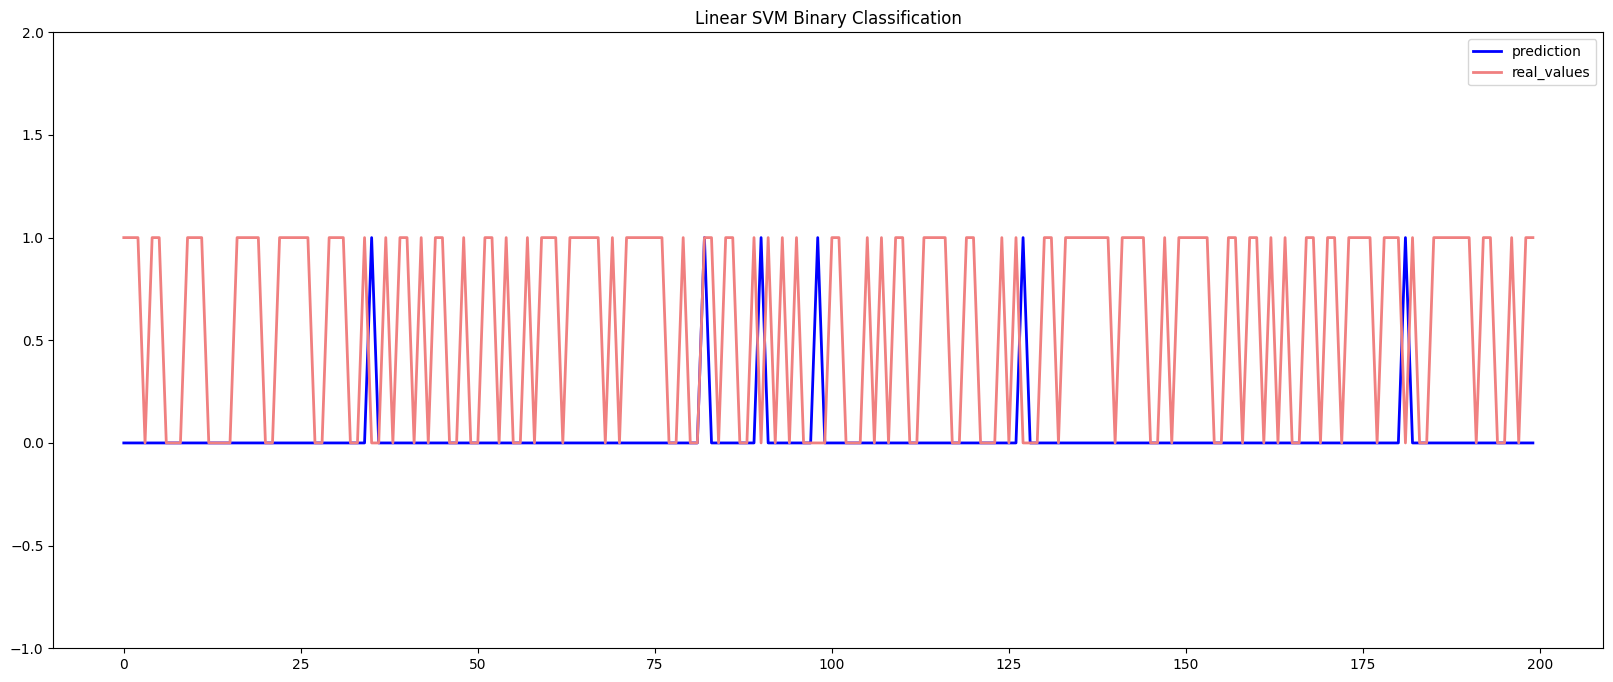

In [18]:
if svm_enable:
  plt.figure(figsize=(20,8))
  plt.plot(y_pred[300:500], label="prediction", linewidth=2.0,color='blue')
  plt.plot(y_test[300:500].values, label="real_values", linewidth=2.0,color='lightcoral')
  plt.legend(loc="best")
  plt.ylim((-1,2))
  plt.title("Linear SVM Binary Classification")
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/lsvm_real_pred_bin.png')
  plt.show()

In [19]:
if svm_enable:
  target_names = ['class 0', 'class 1']
  print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.35      0.96      0.52     23243
     class 1       0.40      0.02      0.03     41176

    accuracy                           0.36     64419
   macro avg       0.38      0.49      0.27     64419
weighted avg       0.38      0.36      0.21     64419



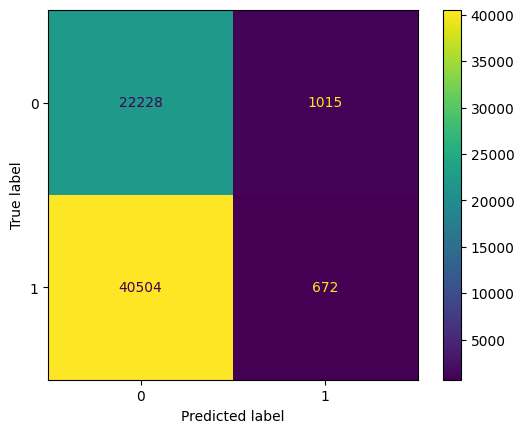

In [20]:
if svm_enable:
  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

  clf = lsvm
  cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)
  disp.plot()

  plt.show()

## **Multi Layer Perceptron Classifier (Binary Classification)**

In [21]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  mlp = Sequential() # creating model

  # adding input layer and first layer with 50 neurons
  mlp.add(Dense(units=50, input_dim=X_train.shape[1], activation='relu'))
  # output layer with sigmoid activation
  mlp.add(Dense(units=1,activation='sigmoid'))

In [22]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # defining loss function, optimizer, metrics and then compiling model
  mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # summary of model layers
  mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                9950      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,001
Trainable params: 10,001
Non-trainable params: 0
_________________________________________________________________


In [24]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # training the model on training dataset
  history = mlp.fit(X_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
31/31 [==============================] - 3s 21ms/step - loss: 0.5883 - accuracy: 0.7583 - val_loss: 0.4869 - val_accuracy: 0.8476
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.4213 - accuracy: 0.8633 - val_loss: 0.3592 - val_accuracy: 0.8839
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 0.3114 - accuracy: 0.9272 - val_loss: 0.2628 - val_accuracy: 0.9479
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.2274 - accuracy: 0.9510 - val_loss: 0.1928 - val_accuracy: 0.9535
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.1663 - accuracy: 0.9629 - val_loss: 0.1402 - val_accuracy: 0.9789
Epoch 6/100
31/31 [==============================] - 0s 14ms/step - loss: 0.1222 - accuracy: 0.9862 - val_loss: 0.1039 - val_accuracy: 0.9936
Epoch 7/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0912 - accuracy: 0.9952 - val_loss: 0.0788 - val_accuracy: 0.9975
Epoch 8/1

In [25]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  filepath = '/content/drive/MyDrive/Colab_Notebooks/Models/mlp_binary.json'
  weightspath = '/content/drive/MyDrive/Colab_Notebooks/Weights/mlp_binary.h5'
  if (not path.isfile(filepath)):
    # serialize model to JSON
    mlp_json = mlp.to_json()
    with open(filepath, "w") as json_file:
      json_file.write(mlp_json)

    # serialize weights to HDF5
    mlp.save_weights(weightspath)
    print("Saved model to disk")

    # load json and create model
    json_file = open(filepath, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    mlp = model_from_json(loaded_model_json)

    # load weights into new model
    mlp.load_weights(weightspath)
    print("Loaded model from disk")

In [26]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # defining loss function, optimizer, metrics and then compiling model
  mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # predicting target attribute on testing dataset
  test_results = mlp.evaluate(X_test, y_test, verbose=1)
  print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}')

2014/2014 [==============================] - 6s 3ms/step - loss: 97695104.0000 - accuracy: 0.6985
Test results - Loss: 97695104.0 - Accuracy: 69.84740495681763


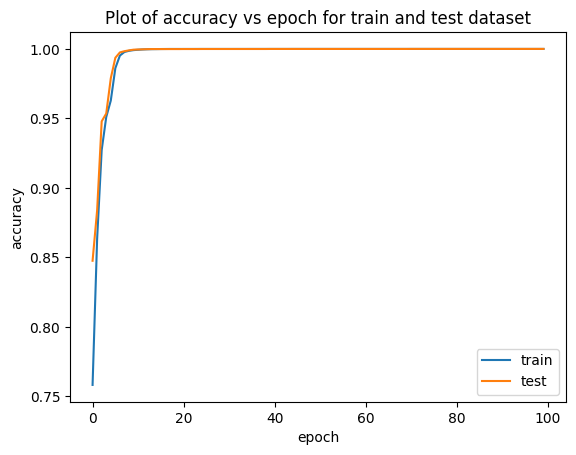

In [28]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":  
  # Plot of accuracy vs epoch of train and test dataset
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title("Plot of accuracy vs epoch for train and test dataset")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/mlp_binary_accuracy.png')
  plt.show()

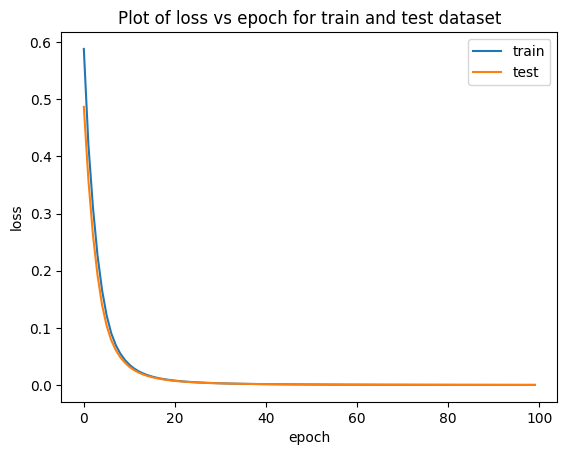

In [29]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # Plot of loss vs epoch of train and test dataset
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Plot of loss vs epoch for train and test dataset')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/mlp_binary_loss.png')
  plt.show()

In [30]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  # representation of model layers
  from keras.utils.vis_utils import plot_model
  plot_model(mlp, to_file='/content/drive/MyDrive/Colab_Notebooks/Plots/mlp_binary.png', show_shapes=True,)

In [31]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  y_pred = mlp.predict(X_test).ravel()
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  auc = auc(fpr, tpr)

2014/2014 [==============================] - 3s 2ms/step


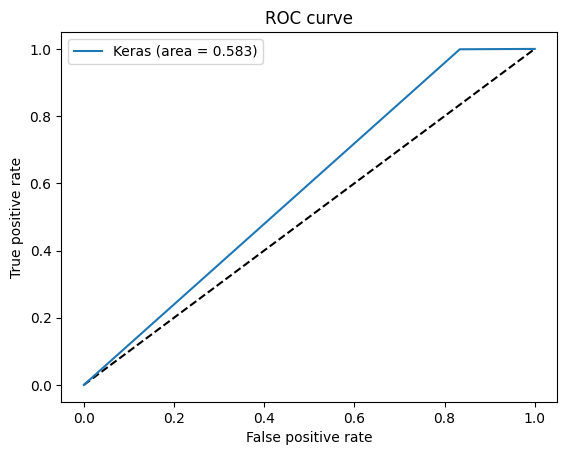

In [32]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/mlp_binary_roc.png')
  plt.show()

In [33]:
# real_data_kdd = bin_data.copy()

# # Names of the columns that are discrete
# cat_cols = real_data_kdd.select_dtypes(['object']).columns
# # cat_cols
# test_data = real_data_kdd.iloc[:999]

# corr= test_data.corr()
# corr_y = abs(corr['label'])
# highest_corr = corr_y
# highest_corr.sort_values(ascending=True)

In [34]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  y_classes = (mlp.predict(X_test)>0.5).astype('int32')

2014/2014 [==============================] - 3s 2ms/step


In [35]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "MLP":
  print("Recall Score - ",recall_score(y_test,y_classes))
  print("F1 Score - ",f1_score(y_test,y_classes))
  print("Precision Score - ",precision_score(y_test,y_classes))

Recall Score -  0.998955702350884
F1 Score -  0.8089881010915528
Precision Score -  0.6797270053210828


              precision    recall  f1-score   support

           0       0.99      0.17      0.28     23243
           1       0.68      1.00      0.81     41176

    accuracy                           0.70     64419
   macro avg       0.83      0.58      0.55     64419
weighted avg       0.79      0.70      0.62     64419



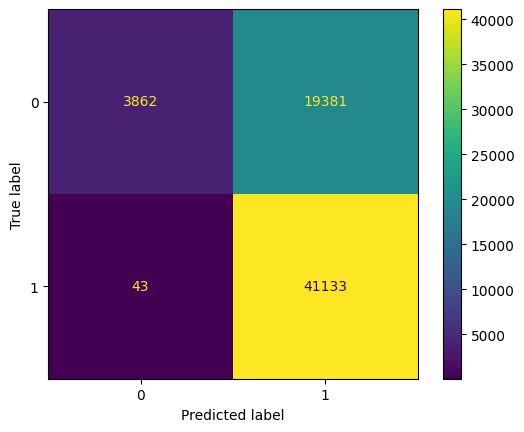

In [36]:
print(classification_report(y_test, y_classes, target_names=['0', '1']))
cm = confusion_matrix(y_test, y_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['0', '1'])
disp.plot()

plt.show()

# **Correlation** Matrix of Features

In [37]:
corr= bin_data.corr()
corr_y = abs(corr['label'])
highest_corr = corr_y[corr_y >0.3]
highest_corr.sort_values(ascending=True)

state_FIN           0.309305
ct_src_dport_ltm    0.318518
rate                0.335883
dwin                0.339166
state_CON           0.345195
dload               0.352169
swin                0.364877
proto_tcp           0.364981
ct_dst_sport_ltm    0.371672
ct_state_ttl        0.476559
id                  0.490584
state_INT           0.516735
sttl                0.624082
label               1.000000
Name: label, dtype: float64

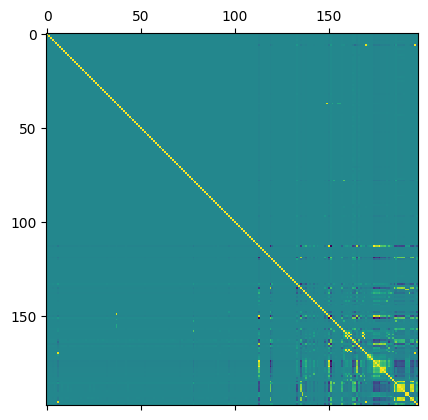

In [38]:
plt.matshow(corr)
plt.show()

## **LSTM Classifier**

In [56]:
X_train = np.array(X_train)
X_test = np.array(X_test)
# y_train.shape   #(18896,)
X_train.shape

(193254, 198)

In [57]:
y_train = np.array(y_train)
type(y_train)

numpy.ndarray

In [58]:
x_train = np.reshape(X_train, (X_train.shape[0],1,X_train.shape[1]))
x_train.shape

(193254, 1, 198)

In [59]:
x_train.shape[2]

198

In [60]:
x_test = np.reshape(X_test, (X_test.shape[0],1,X_test.shape[1]))
x_test.shape

(64419, 1, 198)

In [61]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  lst = Sequential()
  # input layer and LSTM layer with 50 neurons
  input_features = x_train.shape[2]
  lst.add(LSTM(50,input_dim=input_features))

  # outpute layer with sigmoid activation
  lst.add(Dense(1,activation='sigmoid'))

In [62]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # defining loss function, optimizer, metrics and then compiling model
  lst.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [63]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # summary of model layers
  lst.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                49800     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 49,851
Trainable params: 49,851
Non-trainable params: 0
_________________________________________________________________


In [64]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # training the model on training dataset
  history = lst.fit(x_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
31/31 [==============================] - 3s 25ms/step - loss: 0.6270 - accuracy: 0.7799 - val_loss: 0.5596 - val_accuracy: 0.7975
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.4980 - accuracy: 0.8258 - val_loss: 0.4352 - val_accuracy: 0.8423
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.3827 - accuracy: 0.8641 - val_loss: 0.3286 - val_accuracy: 0.8964
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.2836 - accuracy: 0.9350 - val_loss: 0.2382 - val_accuracy: 0.9489
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.2035 - accuracy: 0.9501 - val_loss: 0.1691 - val_accuracy: 0.9505
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 0.1445 - accuracy: 0.9588 - val_loss: 0.1206 - val_accuracy: 0.9752
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 0.1037 - accuracy: 0.9852 - val_loss: 0.0872 - val_accuracy: 0.9945
Epoch 8/100


In [65]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  filepath = '/content/drive/MyDrive/Colab_Notebooks/Models/lst_binary_unsw_nb15.json'
  weightspath = '/content/drive/MyDrive/Colab_Notebooks/Weights/lst_binary_unsw_nb15.h5'
  if (not path.isfile(filepath)):
    # serialize model to JSON
    lst_json = lst.to_json()
    with open(filepath, "w") as json_file:
      json_file.write(lst_json)

    # serialize weights to HDF5
    lst.save_weights(weightspath)
    print("Saved model to disk")

    # load json and create model
    json_file = open(filepath, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    lst = model_from_json(loaded_model_json)

    # load weights into new model
    lst.load_weights(weightspath)
    print("Loaded model from disk")

Saved model to disk
Loaded model from disk


In [66]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # load json and create model
  json_file = open(filepath, 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  lst = model_from_json(loaded_model_json)

  # load weights into new model
  lst.load_weights(weightspath)
  print("Loaded model from disk")

Loaded model from disk


In [67]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # defining loss function, optimizer, metrics and then compiling model
  lst.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [68]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # predicting target attribute on testing dataset
  test_results = lst.evaluate(x_test, y_test, verbose=1)
  print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

2014/2014 [==============================] - 7s 3ms/step - loss: 1.4377 - accuracy: 0.3928
Test results - Loss: 1.4376606941223145 - Accuracy: 39.27878439426422%


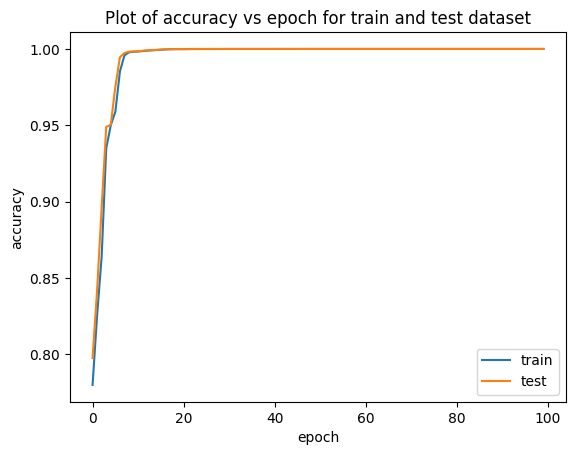

In [69]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # Plot of accuracy vs epoch of train and test dataset
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title("Plot of accuracy vs epoch for train and test dataset")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/lstm_binary_accuracy.png')
  plt.show()

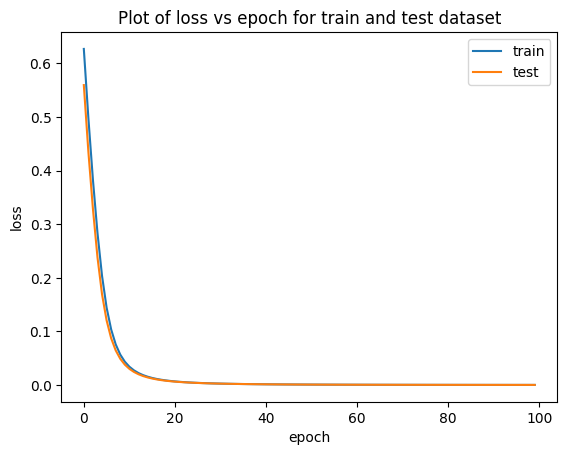

In [70]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # Plot of loss vs epoch of train and test dataset
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title("Plot of loss vs epoch for train and test dataset")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/lstm_binary_loss.png')
  plt.show()

In [71]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  # representation of model layers
  plot_model(lst, to_file='/content/drive/MyDrive/Colab_Notebooks/Plots/lstm_binary.png', show_shapes=True,)

In [72]:
y_test = np.array(y_test)
y_test.shape

(64419,)

In [73]:
type(y_test)

numpy.ndarray

In [74]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  y_classes = (lst.predict(x_test)>0.5).astype('int32')

2014/2014 [==============================] - 4s 2ms/step


In [75]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "LSTM":
  print("Recall Score - ",recall_score(y_test,y_classes))
  print("F1 Score - ",f1_score(y_test,y_classes))
  print("Precision Score - ",precision_score(y_test,y_classes))

Recall Score -  0.18641927336312414
F1 Score -  0.28185356539619594
Precision Score -  0.5774902196810111


              precision    recall  f1-score   support

           0       0.34      0.76      0.47     23243
           1       0.58      0.19      0.28     41176

    accuracy                           0.39     64419
   macro avg       0.46      0.47      0.38     64419
weighted avg       0.49      0.39      0.35     64419



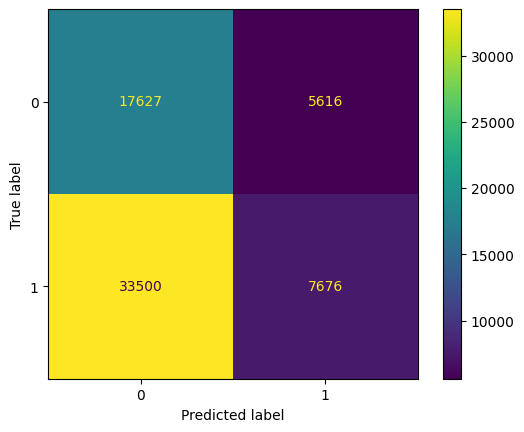

In [76]:
print(classification_report(y_test, y_classes, target_names=['0', '1']))
cm = confusion_matrix(y_test, y_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['0', '1'])
disp.plot()

plt.show()

## **Auto Encoder**

In [77]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # splitting the dataset 75% for training and 25% testing
  X_train, X_test = train_test_split(bin_data, test_size=0.25, random_state=42)

In [78]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # dataset excluding target attribute (encoded, one-hot-encoded,original)
  X_train = X_train.drop(['label'],axis=1) 

  y_test = X_test['label'] # target attribute

  # dataset excluding target attribute (encoded, one-hot-encoded,original)
  X_test = X_test.drop(['label'],axis=1)
  # calling the normalization() function
  X_train = normalization_train(X_train,numeric_cols)
  X_test = normalization_test(X_test,numeric_cols)
  X_train = X_train.values
  X_test = X_test.values
  y_test = y_test.values

In [79]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  input_dim = X_train.shape[1]
  encoding_dim = 50

  #input layer
  input_layer = Input(shape=(input_dim, ))
  #encoding layer with 50 neurons
  encoder = Dense(encoding_dim, activation="relu")(input_layer)           
  #decoding and output layer
  output_layer = Dense(input_dim, activation='softmax')(encoder)

In [80]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # creating model with input, encoding, decoding, output layers
  autoencoder = Model(inputs=input_layer, outputs=output_layer)

  # defining loss function, optimizer, metrics and then compiling model
  autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

In [81]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # summary of model layers
  autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 197)]             0         
                                                                 
 dense_4 (Dense)             (None, 50)                9900      
                                                                 
 dense_5 (Dense)             (None, 197)               10047     
                                                                 
Total params: 19,947
Trainable params: 19,947
Non-trainable params: 0
_________________________________________________________________


In [82]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # training the model on training dataset
  history = autoencoder.fit(X_train, X_train, epochs=100,batch_size=500,validation_data=(X_test, X_test)).history

Epoch 1/100
387/387 [==============================] - 4s 6ms/step - loss: 0.0236 - accuracy: 0.3576 - val_loss: 29489732933124096.0000 - val_accuracy: 0.0000e+00
Epoch 2/100
387/387 [==============================] - 2s 4ms/step - loss: 0.0215 - accuracy: 0.2625 - val_loss: 29489732933124096.0000 - val_accuracy: 0.0000e+00
Epoch 3/100
387/387 [==============================] - 2s 4ms/step - loss: 0.0214 - accuracy: 0.1797 - val_loss: 29489732933124096.0000 - val_accuracy: 0.0000e+00
Epoch 4/100
387/387 [==============================] - 2s 4ms/step - loss: 0.0214 - accuracy: 0.1400 - val_loss: 29489732933124096.0000 - val_accuracy: 0.0000e+00
Epoch 5/100
387/387 [==============================] - 2s 4ms/step - loss: 0.0214 - accuracy: 0.1680 - val_loss: 29489732933124096.0000 - val_accuracy: 0.0000e+00
Epoch 6/100
387/387 [==============================] - 2s 4ms/step - loss: 0.0214 - accuracy: 0.1910 - val_loss: 29489732933124096.0000 - val_accuracy: 0.0000e+00
Epoch 7/100
387/387 [=

In [83]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  filepath = '/content/drive/MyDrive/Colab_Notebooks/Models/ae_binary_unsw_nb15.json'
  weightspath = '/content/drive/MyDrive/Colab_Notebooks/Weights/ae_binary_unsw_nb15.h5'
  if (not path.isfile(filepath)): 
    # serialize model to JSON
    autoencoder_json = autoencoder.to_json()
    with open(filepath, "w") as json_file:
      json_file.write(autoencoder_json)

    # serialize weights to HDF5
    autoencoder.save_weights(weightspath)
    print("Saved model to disk")

    # load json and create model
    json_file = open(filepath, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    autoencoder = model_from_json(loaded_model_json)

    # load weights into new model
    autoencoder.load_weights(weightspath)
    print("Loaded model from disk")

Saved model to disk
Loaded model from disk


In [84]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # defining loss function, optimizer, metrics and then compiling model
  autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

In [85]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # predicting target attribute on testing dataset
  test_results = autoencoder.evaluate(X_test, X_test, verbose=1)
  print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

2014/2014 [==============================] - 6s 3ms/step - loss: 29489728638156800.0000 - accuracy: 0.0000e+00
Test results - Loss: 2.94897286381568e+16 - Accuracy: 0.0%


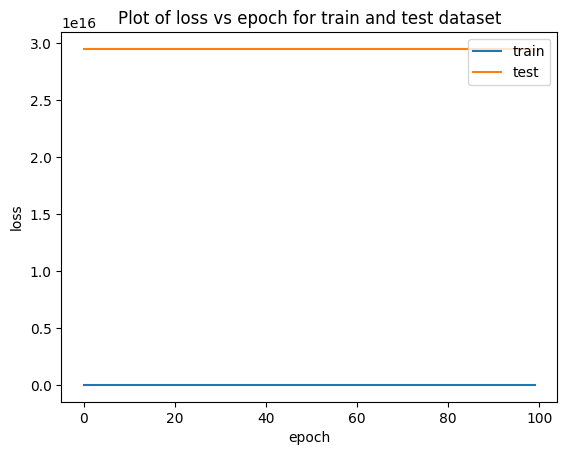

In [86]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # Plot of loss vs epoch of train and test dataset
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title("Plot of loss vs epoch for train and test dataset")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/ae_binary_loss.png')
  plt.show()

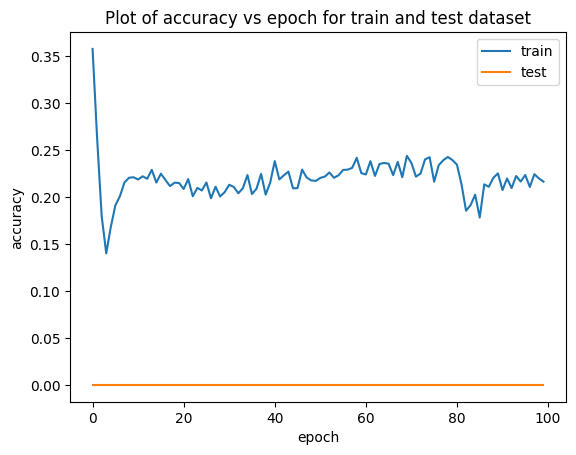

In [87]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # Plot of accuracy vs epoch of train and test dataset
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title("Plot of accuracy vs epoch for train and test dataset")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/ae_binary_accuracy.png')
  plt.show()

In [88]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # representation of model layers
  plot_model(autoencoder, to_file='/content/drive/MyDrive/Colab_Notebooks/Plots/ae_binary.png', show_shapes=True,)

In [89]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # calculating reconstruction error 
  predictions = autoencoder.predict(X_test)

2014/2014 [==============================] - 3s 2ms/step


In [90]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  mse = np.mean(np.power(X_test - predictions, 2), axis=1)
  error_df = pd.DataFrame({'reconstruction_error': mse,
                           'true_class': y_test})

In [91]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  error_df.describe()
  print(predictions.shape)

(64419, 197)


## **AE Classifier**

In [92]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  i_dim = predictions.shape[1]

  #input layer
  i_layer = Input(shape=(i_dim, ))
  #hidden layer with 50 neurons
  fvector = Dense(50, activation="sigmoid")(i_layer)                    
  #doutput layer
  o_layer = Dense(1, activation='sigmoid')(fvector)

In [93]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # creating model with input, encoding, decoding, output layers
  ae_classifier = Model(inputs=i_layer, outputs=o_layer)

  # defining loss function, optimizer, metrics and then compiling model
  ae_classifier.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [94]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # summary of model layers
  ae_classifier.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 197)]             0         
                                                                 
 dense_6 (Dense)             (None, 50)                9900      
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 9,951
Trainable params: 9,951
Non-trainable params: 0
_________________________________________________________________


In [95]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # training the model on training dataset
  his = ae_classifier.fit(predictions, y_test, epochs=300,batch_size=500, validation_split=0.2).history

Epoch 1/300
104/104 [==============================] - 3s 8ms/step - loss: 0.6459 - accuracy: 0.6376 - val_loss: 0.6254 - val_accuracy: 0.6455
Epoch 2/300
104/104 [==============================] - 1s 7ms/step - loss: 0.6172 - accuracy: 0.6376 - val_loss: 0.6050 - val_accuracy: 0.6455
Epoch 3/300
104/104 [==============================] - 0s 4ms/step - loss: 0.6019 - accuracy: 0.6376 - val_loss: 0.5971 - val_accuracy: 0.6527
Epoch 4/300
104/104 [==============================] - 0s 4ms/step - loss: 0.5973 - accuracy: 0.6592 - val_loss: 0.5953 - val_accuracy: 0.6565
Epoch 5/300
104/104 [==============================] - 0s 4ms/step - loss: 0.5963 - accuracy: 0.6645 - val_loss: 0.5952 - val_accuracy: 0.6570
Epoch 6/300
104/104 [==============================] - 0s 5ms/step - loss: 0.5960 - accuracy: 0.6651 - val_loss: 0.5950 - val_accuracy: 0.6570
Epoch 7/300
104/104 [==============================] - 0s 4ms/step - loss: 0.5958 - accuracy: 0.6651 - val_loss: 0.5948 - val_accuracy: 0.6570

In [96]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  filepath = '/content/drive/MyDrive/Colab_Notebooks/Models/ae_classifier_binary_unsw_nb15.json'
  weightspath = '/content/drive/MyDrive/Colab_Notebooks/Weights/ae_classifier_binary_unsw_nb15.h5'
  if (not path.isfile(filepath)): 
    # serialize model to JSON
    ae_classifier_json = ae_classifier.to_json()
    with open(filepath, "w") as json_file:
      json_file.write(ae_classifier_json)

    # serialize weights to HDF5
    ae_classifier.save_weights(weightspath)
    print("Saved model to disk")

    # load json and create model
    json_file = open(filepath, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    ae_classifier = model_from_json(loaded_model_json)

    # load weights into new model
    ae_classifier.load_weights(weightspath)
    print("Loaded model from disk")

Saved model to disk
Loaded model from disk


In [97]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  ae_classifier.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [98]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # predicting target attribute on testing dataset
  test_results = ae_classifier.evaluate(X_test, y_test, verbose=1)
  print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

2014/2014 [==============================] - 6s 3ms/step - loss: 0.6537 - accuracy: 0.6118
Test results - Loss: 0.6536728739738464 - Accuracy: 61.177605390548706%


In [99]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # representation of model layers
  plot_model(ae_classifier, to_file='/content/drive/MyDrive/Colab_Notebooks/Plots/ae_classifier_binary.png', show_shapes=True)

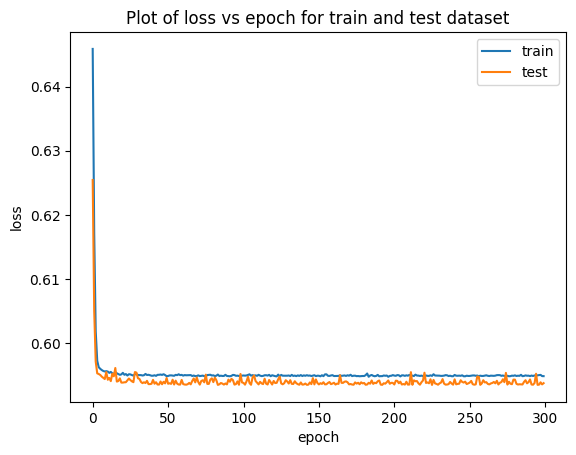

In [100]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # Plot of loss vs epoch of train and test dataset
  plt.plot(his['loss'])
  plt.plot(his['val_loss'])
  plt.title("Plot of loss vs epoch for train and test dataset")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/ae_classifier_binary_loss.png')
  plt.show()

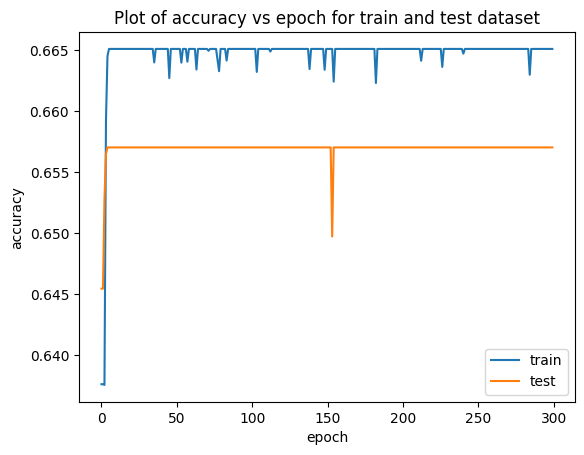

In [101]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  # Plot of accuracy vs epoch of train and test dataset
  plt.plot(his['accuracy'])
  plt.plot(his['val_accuracy'])
  plt.title("Plot of accuracy vs epoch for train and test dataset")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/ae_classifier_binary_accuracy.png')
  plt.show()

In [102]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  y_pred = ae_classifier.predict(X_test).ravel()
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  #auc = auc(fpr, tpr)

2014/2014 [==============================] - 3s 2ms/step


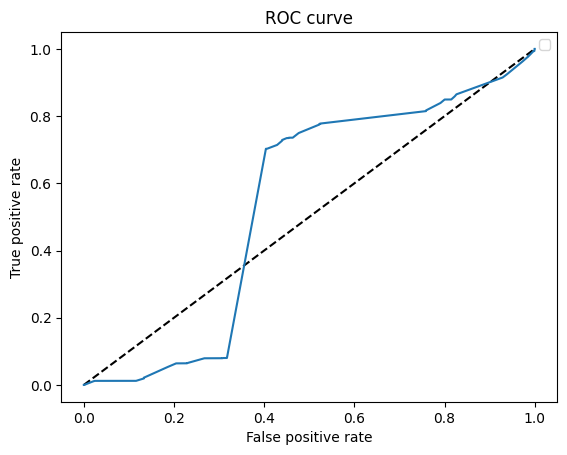

In [103]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  plt.plot([0, 1], [0, 1], 'k--')
  #plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
  plt.plot(fpr, tpr)
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.savefig('/content/drive/MyDrive/Colab_Notebooks/Plots/ae_binary_roc.png')
  plt.show()

In [104]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  pred = ae_classifier.predict(X_test)
  y_classes = (ae_classifier.predict(X_test)>0.5).astype('int32')

2014/2014 [==============================] - 3s 2ms/step


In [105]:
if model_selection[model_flag]=="ALL" or model_selection[model_flag] == "AE":
  print("Recall Score - ",recall_score(y_test,y_classes))
  print("F1 Score - ",f1_score(y_test,y_classes))
  print("Precision Score - ",precision_score(y_test,y_classes))

Recall Score -  0.8391053040606178
F1 Score -  0.7342606071553804
Precision Score -  0.6527061490507226


              precision    recall  f1-score   support

           0       0.42      0.21      0.28     23243
           1       0.65      0.84      0.73     41176

    accuracy                           0.61     64419
   macro avg       0.54      0.52      0.51     64419
weighted avg       0.57      0.61      0.57     64419



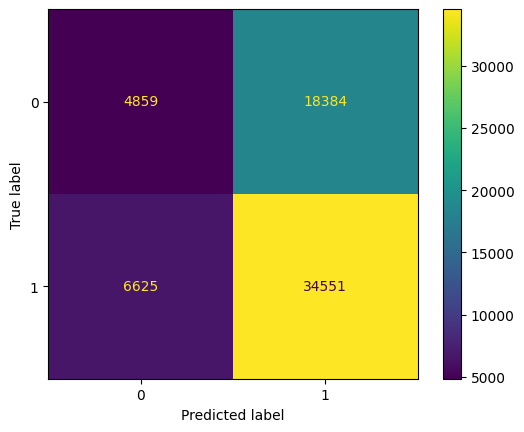

In [106]:
print(classification_report(y_test, y_classes, target_names=['0', '1']))
cm = confusion_matrix(y_test, y_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['0', '1'])
disp.plot()

plt.show()